# Slice sampler

This part is taken from [Robert and Casella (2004)](https://www.springer.com/gp/book/9780387212395).

At iteration $t$, simulate:

\begin{eqnarray}
 u^{(t+1)} &\sim& U_{[0,f(x^{(t)}]} \nonumber \\
 x^{(t+1)} &\sim& U_{A^{(t+1)}} \nonumber
\end{eqnarray}
with $A^{(t+1)} = \{ x: f(x) \geq u^{(t+1)} \}$

## Example 1

In this example, the *slice sampler* will be used to simulate from the density:
\begin{eqnarray}
f(x)=\frac{1}{2}\exp( -\sqrt{x} )
\end{eqnarray}

At iteration *t*, simulate:
\begin{eqnarray}
 u^{(t+1)} &\sim& U_{[0,\frac{1}{2}\exp( -\sqrt{x} )]} \nonumber \\
 x^{(t+1)} &\sim& U_{[0,(-\log(2u))^2]} \nonumber
\end{eqnarray}

In [10]:
import Pkg
Pkg.add("Random")
Pkg.add("Distributions")
Pkg.add("Plots")
Pkg.add("PyPlot")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
┌ Error: curl_easy_setopt: 48
│ 
│ You may be using an old system libcurl library that doesn't understand options that Julia uses. You can try the following Julia code to see which libcurl library you are using:
│ 
│     using Libdl
│     filter!(contains("curl"), dllist())
│ 
│ If this indicates that Julia is not using the libcurl library that is shipped with Julia, then that is likely to be the problem. This either means:
│ 
│   1. You are using an unofficial Julia build which is configured to use a system lib

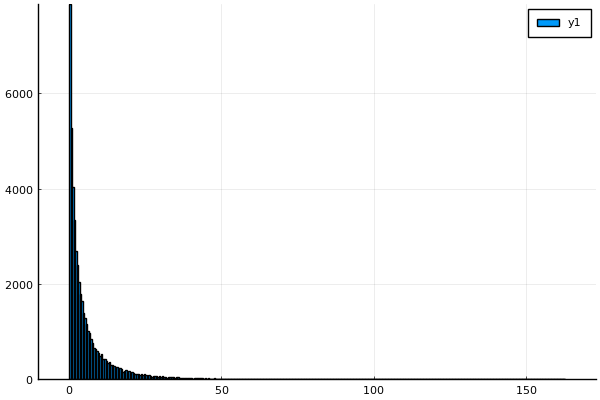

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [12]:
using Random, Distributions

# Setting the seed
Random.seed!(123)

function f(y)
    exp( -sqrt(y) ) / 2
end

nsim = 50000

x = rand(Uniform(0.0,1.0),nsim,1)

x[1] = -log.( rand(Uniform(0.0,1.0)) )

for i in 2:nsim
    w = rand(Uniform(0.0,f(x[i-1])))
    x[i] = rand(Uniform(0.0,(-log.(2*w))^2))
end

# Histogram of density
using Plots; pyplot()
Plots.PyPlotBackend()
histogram(x)

## Example 2

Now we consider a truncated normal distribution $\mathcal{N}$(3,1), which is restricted to the interval [0,1].

In this example, the _slice sampler_ will be used to simulate from the density:
\begin{eqnarray}
f(x) \varpropto f_1(x) = \exp\big( -(x+3)^2/2 \big) \mathbb{1}_{[0,1]}{(x)}
\end{eqnarray}



At iteration $t$, simulate:
\begin{eqnarray}
 u^{(t+1)} &\sim& \exp\big( -(x+3)^2/2 \big) U_{[0,1]} \nonumber \\
 x^{(t+1)} &\sim& U_{[0,(-3+\sqrt{-2\log(u)})]} \nonumber
\end{eqnarray}


In [13]:
Pkg.add("Statistics")

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [10745b16] + Statistics v1.9.0
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


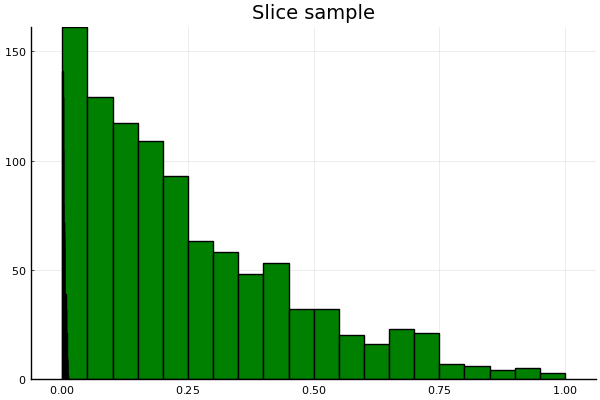

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [14]:
using Random, Statistics, Distributions, Plots

# Sample from a N(-3,1) truncated to [0,1] using the slice sampler
nsim = 1000

obs = zeros(nsim, 2)
obs[1, 1] = 0.25
obs[1, 2] = 0.5 * exp(-0.5 * (obs[1, 1] + 3)^2)

for i in 2:nsim
    obs[i, 2] = exp(-0.5 * (obs[i - 1, 1] + 3)^2) * rand()
    obs[i, 1] = rand() * min(1, -3 + sqrt(-2 * log(obs[i, 2])))
end

histogram(obs, title="Slice sample", legend=false, bins=25, fillcolor=:green)

Sample statistics:
Mean: 0.6815132918081065
Standard deviation: 0.25172464262559807
Minimum: 0.003721093109832485
Maximum: 0.9998410385945574


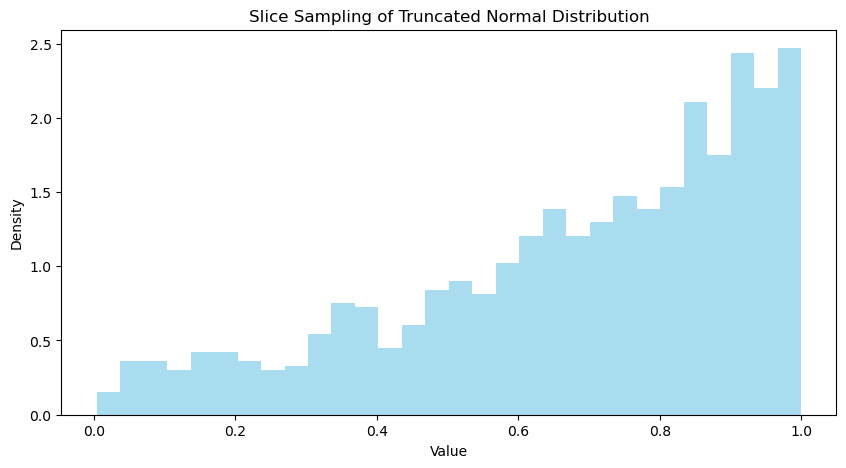

In [3]:
import numpy as np
import scipy.stats as stats

class TruncatedNormalSliceSampler:
    def __init__(self, mu, sigma, lower, upper):
        """
        Initialize the slice sampler for a truncated normal distribution.
        
        Parameters:
        -----------
        mu : float
            Mean of the original normal distribution
        sigma : float
            Standard deviation of the original normal distribution
        lower : float
            Lower bound of the truncation
        upper : float
            Upper bound of the truncation
        """
        self.mu = mu
        self.sigma = sigma
        self.lower = lower
        self.upper = upper
        
        # Create a truncated normal distribution
        self.dist = stats.truncnorm.freeze(
            (lower - mu) / sigma, 
            (upper - mu) / sigma, 
            loc=mu, 
            scale=sigma
        )
    
    def sample(self, num_samples=1, burnin=100, thin=10):
        """
        Perform slice sampling for the truncated normal distribution.
        
        Parameters:
        -----------
        num_samples : int, optional
            Number of samples to generate
        burnin : int, optional
            Number of initial samples to discard
        thin : int, optional
            Thinning parameter to reduce autocorrelation
        
        Returns:
        --------
        numpy.ndarray
            Samples from the truncated normal distribution
        """
        # Initial guess
        current = self.dist.mean()
        samples = []
        
        # Burn-in and sampling
        for i in range(burnin + num_samples * thin):
            # Compute current PDF value
            current_pdf = self.dist.pdf(current)
            
            # Sample height
            height = np.random.uniform(0, current_pdf)
            
            # Find slice boundaries
            left = current
            right = current
            
            # Expand slice to the left
            while left > self.lower and self.dist.pdf(left) > height:
                left -= 0.1
            left = max(left, self.lower)
            
            # Expand slice to the right
            while right < self.upper and self.dist.pdf(right) > height:
                right += 0.1
            right = min(right, self.upper)
            
            # Sample new point within the slice
            while True:
                proposed = np.random.uniform(left, right)
                if self.dist.pdf(proposed) > height:
                    current = proposed
                    break
            
            # Store sample after burn-in and thinning
            if i >= burnin and (i - burnin) % thin == 0:
                samples.append(current)
        
        return np.array(samples)

# Example usage
if __name__ == "__main__":
    # Create a slice sampler for a truncated normal distribution
    # Mean = 3, Std Dev = 1, Lower bound = 0, Upper bound = 1
    sampler = TruncatedNormalSliceSampler(mu=3, sigma=1, lower=0, upper=1)
    
    # Generate samples
    samples = sampler.sample(num_samples=1000)
    
    # Validate samples
    print("Sample statistics:")
    print(f"Mean: {np.mean(samples)}")
    print(f"Standard deviation: {np.std(samples)}")
    print(f"Minimum: {np.min(samples)}")
    print(f"Maximum: {np.max(samples)}")
    
    # Optional: Visualize the samples
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.hist(samples, bins=30, density=True, alpha=0.7, color='skyblue')
    plt.title("Slice Sampling of Truncated Normal Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()